## Accuracy=99.75% 



In [1]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

2022-04-16 15:59:50.542621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-16 15:59:50.542642: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Load 42,000 training images and 28,000 test images

In [2]:
# Loading MNIST Training and Test Data
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")


In [3]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

X_train = X_train / 255.0
test = test / 255.0


In [4]:
# train.head()

In [5]:
# test.head()

In [6]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

## Plot Images before Augmentation

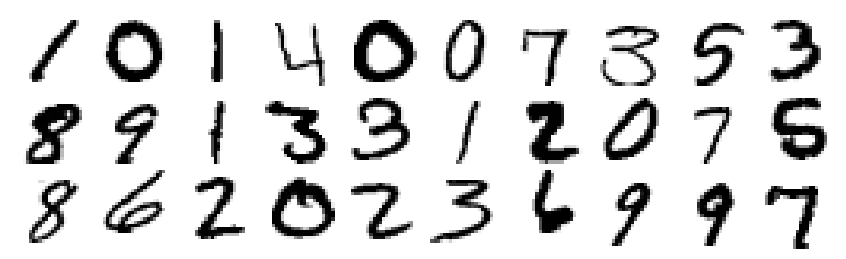

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

## Augmentation 

Following Augmentation have been applied on this set of 42,000 images training images.

### rotation_range:

To randomly rotate images through any degree between 0 and 360 by providing an integer value in the rotation_range argument.

When the image is rotated, some pixels will move outside the image and leave an empty area that needs to be filled in. You can fill this in different ways like a constant value or nearest pixel values, etc. This is specified in the fill_mode argument and the default value is “nearest” which simply replaces the empty area with the nearest pixel values.


### zoom_range = 0.10,  


### Random Shifts with width_shift_range and height_shift_range

It may happen that the object may not always be in the center of the image. To overcome this problem we can shift the pixels of the image either horizontally or vertically; this is done by adding a certain constant value to all the pixels.

ImageDataGenerator class has the argument height_shift_range for a vertical shift of image and width_shift_range for a horizontal shift of image. If the value is a float number, that would indicate the percentage of width or height of the image to shift. Otherwise, if it is an integer value then simply the width or height are shifted by those many pixel values.



### vertical_flip and horizontal_flip

ImageDataGenerator class has parameters horizontal_flip and vertical_flip  for flipping along the vertical or the horizontal axis. However, this technique should be according to the object in the image. For example, vertical flipping of a car would not be a sensible thing compared to doing it for a symmetrical object like football or something else. 


### brightness_range

Brightness can be controlled in the ImageDataGenrator class through the brightness_range argument. It accepts a list of two float values and picks a brightness shift value from that range. Values less than 1.0 darkens the image, whereas values above 1.0 brighten the image.

In [8]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.2,1.1],
        )

In [9]:
X_train.shape # (42000, 28, 28, 1)
X_train[25,].shape # (28, 28, 1)
X_train[25,].reshape((1,28,28,1)).shape # (1, 28, 28, 1)


(1, 28, 28, 1)

### Each row of the total 42,000 rows represent a single image - now take a single one from them. lets say the image at row-index number 25

In [10]:
X_train[25,].shape

(28, 28, 1)

In [11]:
X_train[41999,].shape

(28, 28, 1)

### First see what this 25-ros index image is

So below plot is before Augmentation

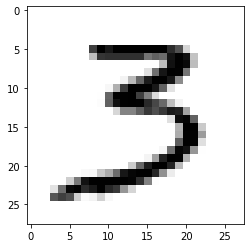

In [12]:
plt.imshow(X_train[25,].reshape((28,28)),cmap=plt.cm.binary)
# plt.imshow(X_train[11,].reshape((28,28)),cmap=plt.cm.binary)
# plt.imshow(X_train[18,].reshape((28,28)),cmap=plt.cm.binary)

### Meaning of X_train[25,] in above

X_train[25,] => Will return all the columns but only row-index number 9
( See my note in slice-notation-with-comma-FOR-NUMPY-ARRAY.ipynb)

In [13]:
len(X_train[41999, ])

28

## Plot a single Augmented Images by taking a single row of of data from the 42,000 number of samples

X_train[25,] => Will return all the columns but only row-index number 9

But to plot with the use of `datagen.flow` - I have to convert the above randomly selected row to a 4-D Tensor of shape `(1,28,28,1)`

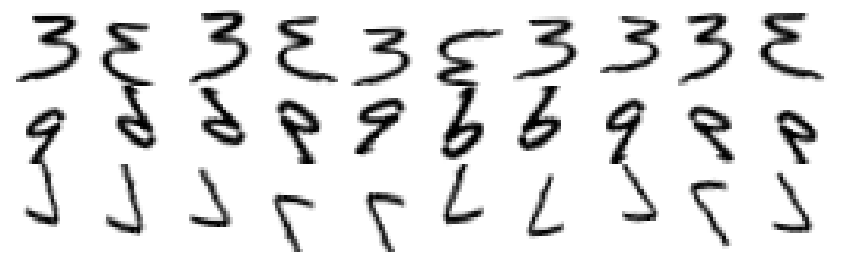

In [14]:
X_train_random = X_train[25,].reshape((1,28,28,1))
Y_train_random = Y_train[25,].reshape((1,10))

plt.figure(figsize=(15,4.5))

for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train_augmented, Y_train_augmented = datagen.flow(X_train_random,Y_train_random).next()
    plt.imshow(X_train_augmented[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    # Now for the second and third row take 2 different digit
    # 9 and 7 respectively
    # And because I am printing 9 columns for the same image, I have to 
    # advance the 'i' value by 10
    if i==9:
        X_train_random = X_train[11,].reshape((1,28,28,1))
    if i==19:
        X_train_random = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

### What is `datagen.flow`

# Build 15 Convolutional Neural Networks!

In [17]:
def build_model(num_cnn):
    model = [0] *num_cnn
    for j in range(num_cnn):
        model[j] = Sequential()

        model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Dropout(0.4))

        model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Dropout(0.4))

        model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Flatten())
        model[j].add(Dropout(0.4))
        model[j].add(Dense(10, activation='softmax'))

        # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
        model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model
    

In [20]:
num_cnn=15
model = build_model(num_cnn)

In [ ]:
# # BUILD CONVOLUTIONAL NEURAL NETWORKS
# num_cnn = 15
# model = [0] *num_cnn
# for j in range(num_cnn):
#     model[j] = Sequential()

#     model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
#     model[j].add(BatchNormalization())
#     model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
#     model[j].add(BatchNormalization())
#     model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
#     model[j].add(BatchNormalization())
#     model[j].add(Dropout(0.4))

#     model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
#     model[j].add(BatchNormalization())
#     model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
#     model[j].add(BatchNormalization())
#     model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
#     model[j].add(BatchNormalization())
#     model[j].add(Dropout(0.4))

#     model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
#     model[j].add(BatchNormalization())
#     model[j].add(Flatten())
#     model[j].add(Dropout(0.4))
#     model[j].add(Dense(10, activation='softmax'))

#     # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
#     model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Architectural highlights
![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/LeNet5.png)

The CNNs in this kernel follow [LeNet5's][1] design (pictured above) with the following improvements:  
* Two stacked 3x3 filters replace the single 5x5 filters. These become nonlinear 5x5 convolutions
* A convolution with stride 2 replaces pooling layers. These become learnable pooling layers.
* ReLU activation replaces sigmoid.
* Batch normalization is added
* Dropout is added
* More feature maps (channels) are added
* An ensemble of 15 CNNs with bagging is used  
  
Experiments [(here)][2] show that each of these changes improve classification accuracy.

[1]:http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
[2]:https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

# Train 15 CNNs

In [22]:
def train():
    # DECREASE LEARNING RATE EACH EPOCH
    lr_scheduler = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
    # TRAIN NETWORKS
    history = [0] * num_cnn
    epochs = 45
    for cnn in range(num_cnn):
        X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
            X_train, Y_train, test_size=0.1
        )
        history[cnn] = model[cnn].fit_generator(
            datagen.flow(X_train_split, Y_train_split, batch_size=64),
            epochs=epochs,
            steps_per_epoch=X_train_split.shape[0] // 64,
            validation_data=(X_val_split, Y_val_split),
            callbacks=[lr_scheduler],
            verbose=0,
        )
        print(
            "CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                cnn + 1,
                epochs,
                max(history[cnn].history["acc"]),
                max(history[cnn].history["val_acc"]),
            )
        )

In [ ]:
train()

In [ ]:
# # DECREASE LEARNING RATE EACH EPOCH
# lr_scheduler = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# # TRAIN NETWORKS
# history = [0] * num_cnn
# epochs = 45
# for cnn in range(num_cnn):
#     X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
#         X_train, Y_train, test_size=0.1
#     )
#     history[cnn] = model[cnn].fit_generator(
#         datagen.flow(X_train_split, Y_train_split, batch_size=64),
#         epochs=epochs,
#         steps_per_epoch=X_train_split.shape[0] // 64,
#         validation_data=(X_val_split, Y_val_split),
#         callbacks=[lr_scheduler],
#         verbose=0,
#     )
#     print(
#         "CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
#             cnn + 1,
#             epochs,
#             max(history[cnn].history["acc"]),
#             max(history[cnn].history["val_acc"]),
#         )
#     )

## What does `model[cnn].fit_generator` do


---

# Ensemble 15 CNN predictions and submit

In [ ]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (X_test.shape[0],10) ) 
for j in range(num_cnn):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

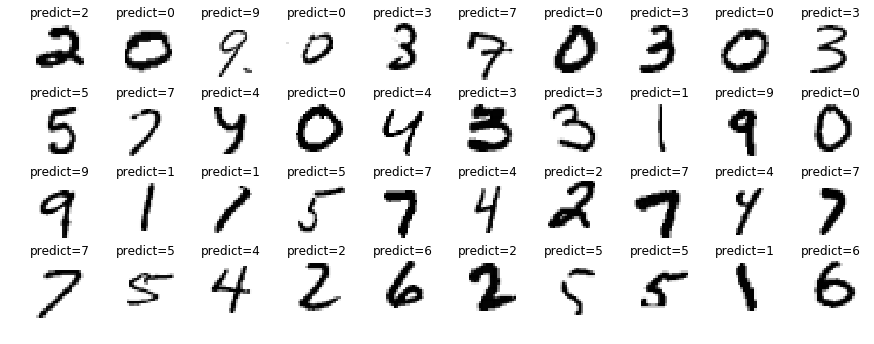

In [ ]:
# PREVIEW PREDICTIONS
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

### Credits

This following great NBs have been great reference for this NB

